In [237]:
# TODO

# call jax.scipy.sparse.linalg.cg to solve for JVP of gradient of parameters w.r.t hyperparameters
# compute the full gradient of the outer objective w.r.t hyperparameters
# use the hyperparameter gradient + ADAM to optimize w.r.t the hyperparameters

# fine-tune subsequent inner optimizations from precomputed optima
# check that computations of A, B, u, v, and grad_theta are correct

In [2]:
"""
Implicit differentiation of lasso.
==================================
"""

from absl import app
from absl import flags

import jax
import jax.numpy as jnp
from jax.scipy.sparse.linalg import cg as conjugate_gradient
from jax import jvp, grad, jacobian

from jaxopt import BlockCoordinateDescent
from jaxopt import objective
from jaxopt import OptaxSolver
from jaxopt import prox
from jaxopt import ProximalGradient
import optax

from sklearn import datasets
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def lasso_objective(params, reg, data):
    lam = jnp.exp(reg)
    X_tr, y_tr = data
    y_pred = jnp.dot(X_tr, params)
    mse = jnp.mean((y_pred - y_tr) ** 2) / 2 
    l1_reg = lam * jnp.sum(jnp.abs(params))
    objective = mse + l1_reg # objective = mean squared error plus L1 regularization
    return objective

def outer_objective(params, data):
    """validation loss """
    X_val, y_val = data
    y_pred = jnp.dot(X_val, params)
    loss_value = jnp.mean((y_pred - y_val) ** 2)
    return loss_value

grad_outer = grad(outer_objective)
grad_inner = grad(lasso_objective)

def solve_inner(theta, data):
    reg = jnp.exp(theta)
    X_tr, y_tr = data
    # use lbfgs? or just optimize directly with scipy.
#     clf = linear_model.Lasso(alpha=float(reg))
#     clf.fit(X_tr, y_tr)
#     loss_value = lasso_objective(clf.coef_, reg, (X_tr, y_tr))
    solver = ProximalGradient(
        fun=objective.least_squares,
        prox=prox.prox_lasso,
        implicit_diff=True,
        maxiter=500)

    # The format is run(init_params, hyperparams_prox, *args, **kwargs)
    # where *args and **kwargs are passed to `fun`.
    w_fit = solver.run(np.zeros(X_tr.shape[1]), reg, (X_tr, y_tr)).params
    loss_value = lasso_objective(w_fit, reg, (X_tr, y_tr))
    return loss_value, w_fit

# hessian-vector product
def hvp(f, primals, tangents):
    return jvp(grad(f), primals, tangents)[1] # use jax.jvp

def solve_lasso(theta_init, data, n_steps=500, step_size=1e-3):
    X_tr, X_val, y_tr, y_val = data
    theta = theta_init
    learning_rate = 1e-2
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(theta)
    
    for i in range(n_steps):
        # solve inner problem
        _, w_fit = solve_inner(theta, (X_tr, y_tr))
    
        # solve for hyperparameter gradient with conjugate gradient
        v = grad_outer(w_fit, (X_tr, y_tr))
        B = jacobian(grad_inner, argnums=1)(w_fit, theta, (X_tr, y_tr))

        def matvec_A(u):
            return -jvp(lambda w: grad_inner(w, theta, (X_tr, y_tr)), (w_fit,), (u,))[1]
        
        u = conjugate_gradient(matvec_A, v.T)[0] # compute directly?
        grad_theta = jnp.dot(u.T, B)
        
        print(f'Iteration {i} of {n_steps} theta: {theta}, grad_theta: {grad_theta}')
        
        # gradient descent with ADAM
        updates, opt_state = optimizer.update(grad_theta, opt_state)
        theta = optax.apply_updates(theta, updates)
        
        print(f"Iteration {i} of {n_steps}. theta: {theta}, grad_theta: {grad_theta}, validation loss: {outer_objective(w_fit, (X_val, y_val))}")
    
    return theta, w_fit
        

In [4]:
X, y = datasets.load_diabetes(return_X_y=True)
X = preprocessing.normalize(X)
data = model_selection.train_test_split(X, y, test_size=0.33, random_state=0)

solve_lasso(1.0, data, n_steps=500, step_size=1e-4)

Iteration 0 of 500 theta: 1.0, grad_theta: -45.10622787475586
Iteration 0 of 500. theta: 1.0099999904632568, grad_theta: -45.10622787475586, validation loss: 27122.30859375
Iteration 1 of 500 theta: 1.0099999904632568, grad_theta: -42.64749526977539
Iteration 1 of 500. theta: 1.0199813842773438, grad_theta: -42.64749526977539, validation loss: 27125.09765625
Iteration 2 of 500 theta: 1.0199813842773438, grad_theta: -39.84126663208008
Iteration 2 of 500. theta: 1.0299255847930908, grad_theta: -39.84126663208008, validation loss: 27126.76953125
Iteration 3 of 500 theta: 1.0299255847930908, grad_theta: -37.0155143737793
Iteration 3 of 500. theta: 1.0398130416870117, grad_theta: -37.0155143737793, validation loss: 27128.6328125
Iteration 4 of 500 theta: 1.0398130416870117, grad_theta: -34.28241729736328
Iteration 4 of 500. theta: 1.0496242046356201, grad_theta: -34.28241729736328, validation loss: 27130.232421875
Iteration 5 of 500 theta: 1.0496242046356201, grad_theta: -30.940080642700195

Iteration 44 of 500 theta: 1.1288371086120605, grad_theta: -2.9485793113708496
Iteration 44 of 500. theta: 1.1285080909729004, grad_theta: -2.9485793113708496, validation loss: 27147.83203125
Iteration 45 of 500 theta: 1.1285080909729004, grad_theta: -2.956284523010254
Iteration 45 of 500. theta: 1.1283867359161377, grad_theta: -2.956284523010254, validation loss: 27147.880859375
Iteration 46 of 500 theta: 1.1283867359161377, grad_theta: -2.9850144386291504
Iteration 46 of 500. theta: 1.1284576654434204, grad_theta: -2.9850144386291504, validation loss: 27147.9375
Iteration 47 of 500 theta: 1.1284576654434204, grad_theta: -2.2388949394226074
Iteration 47 of 500. theta: 1.1286594867706299, grad_theta: -2.2388949394226074, validation loss: 27148.2265625
Iteration 48 of 500 theta: 1.1286594867706299, grad_theta: 0.38332080841064453
Iteration 48 of 500. theta: 1.1288191080093384, grad_theta: 0.38332080841064453, validation loss: 27137.017578125
Iteration 49 of 500 theta: 1.1288191080093384

KeyboardInterrupt: 

In [215]:
X, y = datasets.load_diabetes(return_X_y=True)
X = preprocessing.normalize(X)
data = model_selection.train_test_split(X, y, test_size=0.33, random_state=0)
X_tr, X_val, y_tr, y_val = data
print(X_tr.shape)
print(y_tr.shape)

(296, 10)
(296,)


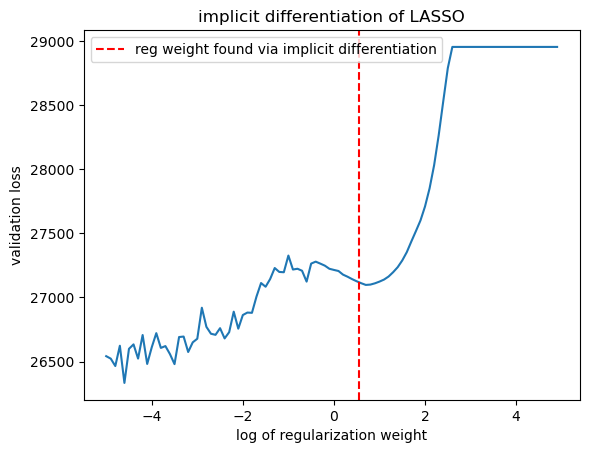

In [211]:
# load data
X, y = datasets.load_diabetes(return_X_y=True)
X = preprocessing.normalize(X)
data = model_selection.train_test_split(X, y, test_size=0.33, random_state=0)
X_tr, X_val, y_tr, y_val = data

results = []
for theta in jnp.arange(-5, 5, 0.1):
    _, w = solve_inner(theta, (X_tr, y_tr))
    val_loss = outer_objective(w, (X_val, y_val))
    results.append([theta, val_loss])

thetas = np.array(results)[:, 0]
loss = np.array(results)[:, 1]
plt.plot(thetas, loss)
plt.axvline(x=0.728526, color='red', linestyle='--', label='reg weight found via implicit differentiation')
plt.xlabel('log of regularization weight')            # Label for x-axis
plt.ylabel('validation loss')            # Label for y-axis
plt.title('implicit differentiation of LASSO')  # Title of the plot
plt.legend()

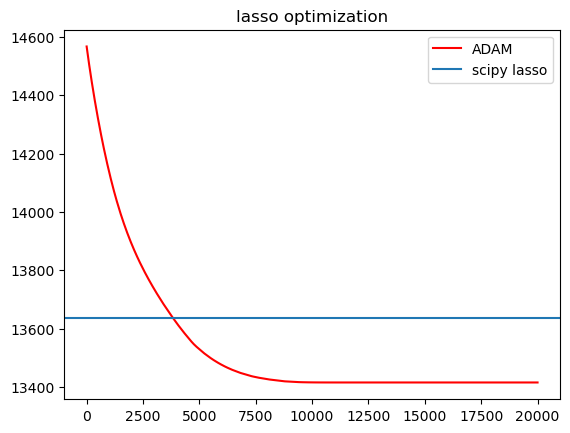

In [201]:
X, y = datasets.load_diabetes(return_X_y=True)
X = preprocessing.normalize(X)

data = model_selection.train_test_split(X, y, test_size=0.33, random_state=0)
X_tr, X_test, y_tr, y_test = data


solver = OptaxSolver(opt=optax.adam(1e-2), fun=lasso_objective) # use gradient descent with ADAM
w = jnp.zeros(X_tr.shape[1])
reg = 0.1
state = solver.init_state(w, reg=reg, data=(X_tr, y_tr))

loss_vals = []
for i in range(20000):
    w, state = solver.update(params=w, state=state, reg=reg, data=(X_tr, y_tr))
    loss_vals.append([i, state.value])
loss_vals = np.array(loss_vals)

clf = linear_model.Lasso(alpha=reg)
clf.fit(X_tr, y_tr)
final_loss = lasso_objective(clf.coef_, reg, (X_tr, y_tr))

plt.title('lasso optimization')
plt.plot(loss_vals[:, 0], loss_vals[:, 1], color='red', label='ADAM')
plt.axhline(y=final_loss, label='scipy lasso')
plt.legend()

0.0
(146, 10) (146,)
0.1
(146, 10) (146,)
0.2
(146, 10) (146,)
0.3
(146, 10) (146,)
0.4
(146, 10) (146,)


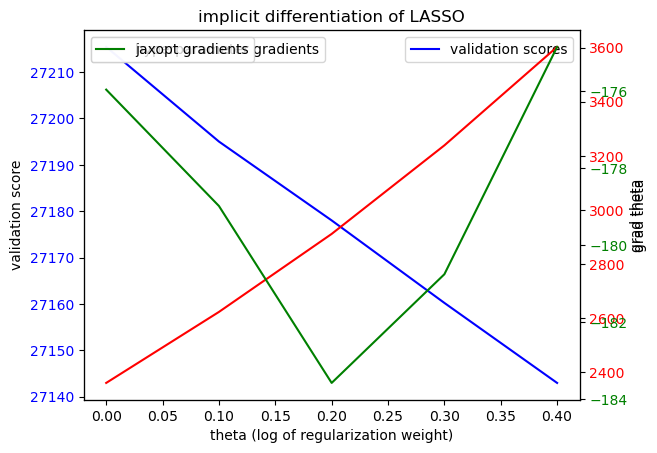

In [10]:
def jaxopt_outer_objective(theta, data):
    """train model with hyperparameters given by jnp.exp(theta) and evaluate validation metric of params"""
    X_tr, X_val, y_tr, y_val = data
    _, w_fit = solve_inner(theta, (X_tr, y_tr))
    print(X_val.shape, y_val.shape)
    loss_value = outer_objective(w_fit, (X_val, y_val))
    return loss_value, w_fit

def hyperparameter_gradient(theta, data):
    X_tr, X_val, y_tr, y_val = data
    _, w_fit = solve_inner(theta, (X_tr, y_tr))
    
    # solve for hyperparameter gradient with conjugate gradient
    v = grad_outer(w_fit, (X_val, y_val))
    B = jacobian(grad_inner, argnums=1)(w_fit, theta, (X_tr, y_tr))

    def matvec_A(u):
        return -jvp(lambda w: grad_inner(w, theta, (X_tr, y_tr)), (w_fit,), (u,))[1]

    u = conjugate_gradient(matvec_A, v.T)[0] # compute directly?
    grad_theta = jnp.dot(u.T, B)

    return grad_theta

# load data
X, y = datasets.load_diabetes(return_X_y=True)
X = preprocessing.normalize(X)
data = model_selection.train_test_split(X, y, test_size=0.33, random_state=0)
X_tr, X_val, y_tr, y_val = data

grad_jaxopt_outer = jax.grad(jaxopt_outer_objective, has_aux=True)

results = []
for theta in jnp.arange(0, 0.5, 0.1):
    print(theta)
    _, w = solve_inner(theta, (X_tr, y_tr))
    val_loss = outer_objective(w, (X_val, y_val))
    grad_theta = hyperparameter_gradient(theta, data)
    jaxopt_grad_theta, _ = grad_jaxopt_outer(theta, data)
    jaxopt_grad_theta = float(jaxopt_grad_theta)
    results.append([theta, val_loss, grad_theta, jaxopt_grad_theta])

thetas = np.array(results)[:, 0]
loss = np.array(results)[:, 1]
grads = np.array(results)[:, 2]
jaxopt_grads = np.array(results)[:, 3]

fig, ax1 = plt.subplots()
ax1.plot(thetas, loss, color='blue', label='validation scores')
ax1.set_xlabel('theta (log of regularization weight)')
ax1.set_ylabel('validation score')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(thetas, grads, color='red', label='hyperparameter gradients')
ax2.set_xlabel('theta (log of regularization weight)')
ax2.set_ylabel('grad theta')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend()
ax3 = ax1.twinx()
ax3.plot(thetas, jaxopt_grads, color='green', label='jaxopt gradients')
ax3.set_xlabel('theta (log of regularization weight)')
ax3.set_ylabel('grad theta')
ax3.tick_params(axis='y', labelcolor='green')
ax3.legend()
#plt.plot(thetas, loss, label='validation loss for theta')
           # Label for y-axis
plt.title('implicit differentiation of LASSO')  # Title of the plot
plt.legend()

In [229]:
print(hyperparameter_gradient(1.5, data))
print()

98.71001
